In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue
from tqdm import tqdm
import os
import shutil
from plot_script import plot_result

# Agent
from agent import ExpectedSarsaAgent

# Environment
from car_racing import CarRacingEnvironment

# Run Experiment

In [6]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        # Start from pre trained weights!
        rl_glue.agent.network.weights = np.load('trained_networks/agent_004_albon.npy', allow_pickle=True)

        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
            #print(episode_reward)

    # Save Results
            save_name = "{}".format(rl_glue.agent.name)
            
            if not os.path.exists('results'):
                os.makedirs('results')
            #np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
            np.save("results/sum_reward_{}".format(save_name), agent_sum_reward[:,:episode])
            shutil.make_archive('results', 'zip', 'results')

    return rl_glue # To get the agent

# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 1000,
    "timeout" : 1000, # timestep limit (set to 500 as default)
}

# Environment parameters
environment_parameters = {}

current_env = CarRacingEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 6, # State Dimension (number of inputs)
        'num_hidden_units': 16, #
        'num_actions': 5 # Action Space (number of outputs)
    },
    'optimizer_config': {
        'step_size': 1e-4, # 1e-3
        'beta_m': 0.9,
        'beta_v': 0.999, # 0.999
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 2,
    'gamma': 0.98,
    'tau': 0.0005 # 0.001
}

current_agent = ExpectedSarsaAgent

# run experiment
rl_glue_return = run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|██████████| 1000/1000 [3:35:20<00:00, 12.92s/it] 


Run the cell below to see the comparison between the agent that you implemented and a random agent for the one run and 300 episodes. Note that the `plot_result()` function smoothes the learning curve by applying a sliding window on the performance measure. 

In [4]:
# Save/Load agent
# np.save('trained_networks/agent_004_albon.npy', rl_glue_return.agent.network.weights)
trained_weights = np.load('trained_networks/agent_004_albon.npy', allow_pickle=True)

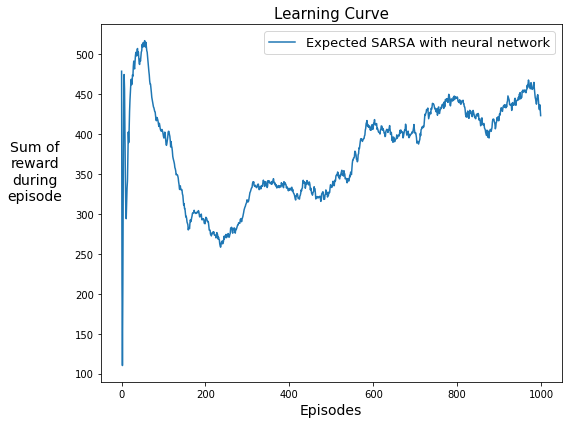

In [7]:
plot_result(["expected_sarsa_agent"])

# Test Car Racing

In [ ]:
rl_glue_return.environment.env_init()
rl_glue_return.environment.rand_generator = np.random.RandomState(0)

In [ ]:
# Start Environment
observation = rl_glue_return.environment.env_start()
transformed_obs = observation = rl_glue_return.transform_state(observation)
transformed_obs

In [ ]:
# Select Action
action = rl_glue_return.agent.policy(transformed_obs)
print(f"Action: {action}")

# Do Action
reward, observation, is_terminal = rl_glue_return.environment.env_step(action)
transformed_obs = transformed_obs = observation = rl_glue_return.transform_state(observation)
print(f"Transformed State: {transformed_obs}")

if is_terminal:
    print("Terminal State")
    observation = rl_glue_return.environment.env_start()

rl_glue_return.environment.env.render();


## Let it run!

In [14]:
# Load NN
#rl_glue_return.agent.network.weights = trained_weights

In [14]:
import time

# Start Environment
rl_glue_return.environment.env_init()
rl_glue_return.environment.rand_generator = np.random.RandomState(9999) # Good ones: 2, 4, 9, 21

# Set tau
rl_glue_return.agent.tau = 0.0000000000001
time_steps = 1000

observation = rl_glue_return.environment.env_start()
transformed_obs = observation = rl_glue_return.transform_state(observation)
episode_reward = 0

for i in tqdm(range(time_steps)):
    
    # Select Action
    action = rl_glue_return.agent.policy(transformed_obs)

    # Do Action
    reward, observation, is_terminal = rl_glue_return.environment.env_step(action)
    transformed_obs = transformed_obs = observation = rl_glue_return.transform_state(observation)

    episode_reward += reward

    if is_terminal:
        message = "Terminal State: Max number of steps completed."
        if i != time_steps-1:
            message = "Terminal State: All tiles visited!"
        print(message)
        print(f'Reward: {episode_reward}')
        break
        observation = rl_glue_return.environment.env_start()

    # Render
    rl_glue_return.environment.env.render();

100%|█████████▉| 999/1000 [00:24<00:00, 40.63it/s]

Terminal State: Max number of steps completed.
Reward: 112.38938053097814


In [15]:
rl_glue_return.environment.env.close();